This is an ipython notebook. Lectures about Python, useful both for beginners and experts, can be found at http://scipy-lectures.github.io.

I recommend installing the [Anaconda](https://store.continuum.io/cshop/academicanaconda) distribution. Make sure not to pay for it! Click Anaconda Academic License; it should be free for those with academic e-mail addresses.

Open the notebook by (1) copying this file into a directory, (2) in that directory typing 
ipython notebook
and (3) selecting the notebook.




In this exercise, we will build a Wright-Fisher simulation model, which will be the basis of most of our simulation efforts. 



# Wright-Fisher model
## Motivation



Population genetics seeks to describe and understand patterns of genetic diversity found in natural and artificial populations. In previous exercises, we've focused on the description part, measuring statistical differences among populations. We were able to interpret these differences in qualitative terms. Some populations seemed more related to each other, some were more distinct, and we could tell stories about that: maybe the more distinct groups were separated for a longer time. However, if we want to really understand the data, we need to go beyond describing it. We need to build models for the data that make predictions and can be falsified. The Hardy-Weinberg equilibrium model was a good start in that direction, but it only predicts a specific aspect of the data: the relationship between allele frequency and heterozygosity. It told us nothing about the number or frequency of variants in a population, or the amount of differences across populations. It didn't tell us how things change over time.             

In this exercise, we will study the evolution of allele frequencies in a finite population. This notebook implements a very simple model of allele frequency evolution that we will use over and over in this course. To build an actual evolutionary model, we need to specify a number of parameters: the population size, the structure of the genome (e.g., the number of chromosomes, its ploidy), the mode of reproduction of the population (e.g., sexual vs asexual), the structure of the population, the distribution of offspring by individual, how new alleles are created, how alleles are transmitted from parent to offspring. We also have to decide on the starting point in our model, the ancestral population from which we will consider evolution. Since this is our first model, we'd like to keep everything as simple as possible:



* Population size:    constant, $N$

* Structure of the genome:   one single haploid chromosome of length 1 base pair. 

* Mode of reproduction:      asexual

* Mutation process:          No mutation

* Transmission:              Asexual transmission (clonal reproduction)

* Distribution of offspring: ?

It was straightforrward to come up with the simplest parameters so far, but here we need to think a bit more. Since we have a haploid population of constant size, the average number of offspring per individual must be one. If every individual has exactly one offspring, the population will never change and the model will be useless, so we need to let parents have different number of offspring.  
If we let each parent independently pick a random number of offspring, the population size could change a little bit at every generation. That's not really a big deal, since real populations sizes do fluctuate, but we'd like to be able to control those fluctuations for two reasons. First, if we happen to know the size of the population we want to model, we don't want to waste time simulating populations of the wrong size. Second, if we want to model a population for a long period of time, the size fluctuations will add up and the population will either go extinct or grow uncontrollably.   


If parents vary in their number of offspring, how can they synchronize to produce exactly one offspring, on average?
One way would be to add feedback, reducing the mean number of offspring when the population size increases, and increasing it when the population size decreases. That could work, but there are many parameters to fix, and even there we're not immune to the occasional population extinction.       


There are a few elegant but slightly strange ways of solving this problem by keeping the population size at an exact, predefined $N$. First, you can imagine that each parent produces very many offspring, but that only $N$ offspring from the entire population are allowed to survive, and these are selected at random among all offspring. You can also turn the table and imagine that each of the allowed $N$ offspring "picks" a parent at random. If the idea of children picking their parents is confusing, you can imagine that there are $N$ child-bearing permits available, and each permit is offered to a randomly-chosen parent. 

Interestingly, these approaches are exactly equivalent, in that they make the exact same predictions about the number of surviving offsprings per parent. **Take the time to convince yourself that this is the case.**

This sampling approach defines the Wright-Fisher model. We can add many features to this model, such as selection, recombination, mutation, and so forth, but as long as you have this discrete generations and random selection of parents, you're within the Wright-Fisher model.       

I'll just mention one alternative, called the Moran Model, which involves replacing a single, randomly selected individual by the genotype of another, randomly selected individual, and repeating this $N$ times per generation. The Moran model is not exactly equivalent to the Wright-Fisher model, and there are cases where it is more convenient. But we'll stick to Wright-Fisher for this notebook.    

*Optional Mathematical exercises*

1. What is the distribution of offspring number per individual in the Wright-Fisher model? 

2. Convince yourself that, for large enough populations, this distribution is approximately Poisson with mean 1. 

## Libraries
We'll need the following python plotting libraries. 

In [1]:
### 1
%matplotlib inline 
#If you run into errors with %matplotlib, check that your version of ipython is >=1.0 
import numpy as np #numpy defines useful functions for manipulating arrays and matrices.
import matplotlib.pyplot as plt #matplotlib is plotting library

## Implementation

We have specified almost everything we needed in the model, except for the initial state of the population. We will suppose that the single site has two alleles labeled $0$ and $1$. We need to specify the number of individuals nInd in the initial population and the proportion $p0$ of $1$ alleles


In [2]:
### 2
p0   = 0.1  # initial proportion of "1" alleles 
nInd = 100  # initial population size (number of individuals)


Now we need to create an initial population with the given number of individuals, and the appropriate proportion of 1 alleles. We'll store the population as a np.array called "initial_population", of length nInd containing 0s and 1s.

In [3]:
### 3
# Initialize a population of length nInd with only 0 alleles. 
initial_population = np.zeros(nInd)

# Set the first p0*nInd alleles to 1.
p1 = int(p0*nInd)
for i in range(p1):
    initial_population[i] = 1


# For added realism, shuffle the population so that the ones are distributed across the sample.
# You can use np.random.shuffle to do this.

np.random.shuffle(initial_population)
print(initial_population)

[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  1.  0.  0.  0.  1.]


To take finite samples from this population, we can use the np.random.choice function. When taking a sample from a population, we can pick each sample only once--the "replace=False" option below tells us that we don't replace the sampled individual in the population before drawing a new one. Read the np.random.choice documentation for more detail! 

In [4]:
### 4
sample_size = 10
np.random.choice(initial_population, sample_size, replace=False )

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

When we take repeated samples from the same population, we can find very different numbers of alternate alleles--we'll have to take this into account when looking at real data!

*Optional Mathematical exercise*
    
    1-What is the distribution of the number of alternate alleles if we sample s individuals in a population with  allele frequency p?

I generated a bunch of samples below, and compare the resulting histogram to plausible probability distributions so that you can pick the one that fits best. If you don't do the math problems, read a bit about the best-fitting one and check that it makes sense. 

### Answer:

From Wikipedia:

In probability theory and statistics, the hypergeometric distribution is a discrete probability distribution that describes the probability of k successes (random draws for which the object drawn has a specified feature) in n draws, without replacement, from a finite population of size N that contains exactly K objects with that feature, wherein each draw is either a success or a failure. In contrast, the binomial distribution describes the probability of k successes in n draws with replacement.

As there is no replacement in the sampling of the individuals from the population, this will follow the hypergeometric distribution. 
The parameters for this distribution will be:
* N = nInd
* K = p0\*(nInd)
* n = 10


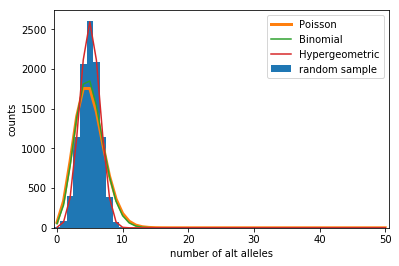

In [5]:
### 5
import scipy
from scipy import stats

iterations = 10000  # the number of times to draw.
sample_size = 50  # the size of each sample
alt_counts = []  # number of alternate alleles (i.e., 1's) for each draw

for i in range(iterations):
    sample=np.random.choice(initial_population, sample_size, replace=False)
    # get the number of alt alleles
    alt_counts.append(sample.sum())
    
# plot a histogram of sampled values    
plt.hist(alt_counts, sample_size + 1, range=(-0.5, sample_size + 1 - 0.5), label="random sample")
plt.xlabel("number of alt alleles")
plt.ylabel("counts")

# Compare this to some discrete distributions
x_range = range(sample_size + 1) # all the possible values

p = np.sum(initial_population) * 1. / len(initial_population)  # initial fraction of alt's

# poisson with mean sample_size * p
y_poisson = stats.poisson.pmf(x_range, sample_size*p) * iterations
# binomial with probability p and  sample_size draws
y_binom = stats.binom.pmf(x_range, sample_size,p) * iterations
# hypergeometric draw of sample_size from population of size len(initial_populationpop)
# with np.sum(initial_population) ones.
y_hypergeom = stats.hypergeom.pmf(x_range, len(initial_population), np.sum(initial_population), sample_size)\
                * iterations

plt.plot(x_range, y_poisson, label="Poisson", lw=3)
plt.plot(x_range, y_binom, label="Binomial")
plt.plot(x_range, y_hypergeom, label="Hypergeometric")
plt.xlim(-0.5, sample_size + 0.5)
plt.legend()

Now comes the time to code up the Wright-Fisher model. Remember that there were two ways of thinking about Wright-Fisher reproduction: 

    1- We generate a very large number of offspring for each parent, and than we take a sample from this very large number of offspring
    2- Each offspring picks a parent at random. 

In 2-, each parent can be chosen multiple times. This is equivalent to taking a sample from the previous generation, but *with replacement*. Convince yourself that this is true. This is *not* optional! If you are not convinced, try programming it both ways, or ask questions. 

Now code a function that takes in a parental population as an array (such as "initial_population", above), and returns an offspring population. 

### Answer:
In the first case, in order to maintain a constant population, we assume that the 'sampled' individuals are the only offspring that survive and are able to reproduce.

In the second case, we work in the opposite direction, choosing the number of offspring equal to the initial population to maintain constant size and then assign them a parent.

In [6]:
### 6
def generation(pop):
    """Takes in a list or array describing an asexual parental population. 
    Return a descendant population according to Wright-Fisher dynamics with constant size"""
    nInd = len(pop) #number of individuals. We could use the global definition of nInd, 
    #but it's better to use the information that is passed to the function 
    #now generate the offspring population.
    return np.random.choice(pop,nInd) 
                    
generation(initial_population)


array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

As for regular sampling, we get a different number of ones every time we run the "generation" function. Here again, I generated a bunch of samples just to get an idea of how much variation there is, and overlaid some plausible distribution. Which one fits best? Does it make sense to you?

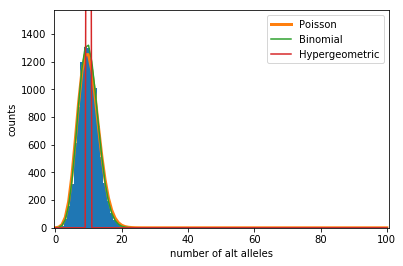

In [7]:
### 7

nsample = 10000  # the number of samples to draw.
alt_counts = []  # number of alternate alleles (i.e., 1's) for each draw

for i in range(nsample):
    offspring = generation(initial_population)
    alt_counts.append(offspring.sum())

hist = plt.hist(alt_counts, len(initial_population)+1, range=(0-0.5, len(initial_population)+0.5))
plt.xlabel("number of alt alleles")
plt.ylabel("counts")

#Here I just check that the initial population is still a list of length nInd
assert nInd==len(initial_population),"initial_population doesn't have the same length as nInd" 

x_range=range(nInd+1)                  #all the possible values
p=np.sum(initial_population)*1./nInd   #the initial frequency

#Compare this to some distributions
y_poisson=stats.poisson.pmf(x_range, nInd*p) * nsample
y_binom=stats.binom.pmf(x_range, nInd, p) * nsample
y_hypergeom=stats.hypergeom.pmf(x_range, nInd, np.sum(initial_population), nInd) * nsample

plt.plot(x_range, y_poisson, label="Poisson",lw=3)
plt.plot(x_range, y_binom, label="Binomial")
plt.plot(x_range, y_hypergeom, label="Hypergeometric")
plt.xlim(-0.5, nInd+0.5)
plt.ylim(0, 1.2*max(hist[0]))
plt.legend()

We observe that the binomial distribution fits the relation between the number of counts to number of alternate alleles best.


In [8]:
### 8
nGen = 100  # number of generations to simulate
history = [initial_population]  # a container list for our simulations. It will contain the population 
                                        # state after generations 0 to nGen
for i in range(nGen):
    # evolve the population for one generation, and append the result to history.
    history.append(generation(history[i])) 
history = np.array(history)  # convert the list into an array for convenient manipulation later on

Now we want to look at the results. Let's compute the allele frequency at each generation and plot that as a function of time.

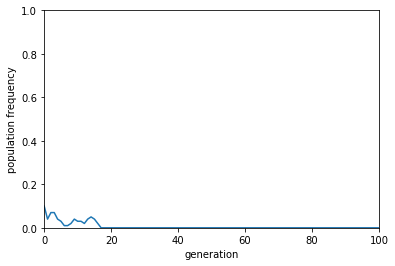

In [9]:
### 9
#compute the allele frequency at each generation.
#freqs should be a list or array of frequencies, with one frequency per generation.
#history is a np array and has two methods that can help you here: sum, and mean. 
#Mean is probably the best bet here. 
freqs = [np.mean(history[i]) for i in range(len(history))]
plt.plot(freqs)
plt.axis([0, 100, 0, 1]);#define the plotting range
plt.xlabel("generation")
plt.ylabel("population frequency")

Now we would like to experiment a bit with the tools that we have developed. Before we do this, we will organize them a bit better, using a Python "class" and object-oriented programming. We have defined above variables that describe a population (such as the population size nInd, and the ancestral frequency g0). We have also defined functions that apply to a population, such as "generation". A class is used to keep track of the relation between objects, variables, and functions. 

If you are not familiar with classes and are having issues, have a look at [this tutorial](http://en.wikibooks.org/wiki/A_Beginner's_Python_Tutorial/Classes#Creating_a_Class). 



    

In [10]:
### 10
class population:
    """
    Initialization call: 
    
    population(nInd,p0)
    requires a number of individuals nInd and an initial frequency p0
    
    Variables:
    nInd: The number of individuals
    p0: the initial allele frequency
    initial_population: an array of nInd alleles
    history: a list of genotypes for each generation 
    traj: an allele frequency trajectory; only defined if getTraj is run. 
    Methods:
    generation: returns the offspring from the current population, whish is also the last one in self.history
    evolve: evolves the population for a fixed number of generations, stores results to self.history
    getTraj: calculates the allele frequency history for the population
    plotTraj: plots the allele frequency history for the population
    
    """
    def __init__(self, nInd, p0): 
        """initialize the population. nInd is the number of individuals. p0 is the initial allele frequency.
        __init__ is a method that, when run, creates a "population" class and defines some of its variables. 
        Here we define this __init__ method but we don't run it, so there is no "population" created yet.  
        In the meantime, we'll refer to the eventual population object as "self".
        We'll eventually create a population by stating something like   
        pop = population(nInd,p0)
        This will call the __init__ function and pass a "population" object to it in lieu of self. 
        """
        self.nInd = nInd
        self.p0 = p0
        #initialize the population
        self.initial_population = np.zeros(nInd) 
        self.initial_population[0 : int(p0*self.nInd)] = 1
        np.random.shuffle(self.initial_population)
        #history is a container that records the genotype at each generation.
        #we'll update this list 
        self.history = [self.initial_population]

    def generation(self): 
        """class methods need "self" as an argument in they definition to know that they apply to a "population" object. 
        The class structure
        gives you a more readable way of calling this function: If we have a population "pop", we can write pop.generation(), and python will know how to pass
        the population as the first argument. Putting the object name upfront often makes code *much* more readable.   
        Takes the last element of the history. 
        Return a descendant population according to Wright-Fisher dynamics with constant size
        """
        return np.random.choice(self.history[-1],len(self.history[-1])) 

    def evolve(self,nGen): 
        """
        This is a method with one additional argument, the number of generations nGen. 
        To call this method on a population "pop", we'd call pop.evolve(nGen). 
        This function can be called many times on the same population. 
        pop.evolve(2)
        pop.evolve(3)
        would evolve the population for 5 generations. 
        For each step, we make a call to the function generation() and append the population to the "self.history" container. 
        """
        for i in range(nGen):
            new_pop = self.generation()
            self.history.append(new_pop)
        self.getTraj()

    def getTraj(self):
        """
        calculates the allele frequency history for the population
        """
        history_array = np.array(self.history)
        self.traj = history_array.mean(axis=1)  
        return self.traj

    def plotTraj(self,ax="auto"):
        """
        plots the allele frequency history for the population
        """
        
        plt.plot(self.traj)
        if ax=="auto":
            plt.axis([0, len(self.history), 0, 1]) 
        else:
            plt.axis(ax)
    

# Exploration
## Drift
We can now define multiple populations, and let them evolve from the same initial conditions.

In [11]:
### 11
nInd = 100
nGen = 30
nRuns = 10
p0 = 0.3
# Create a list of length nRuns containing initial populations 
# with initial frequency p0 and nInd individuals.
pops = [population(nInd, p0) for i in range(nRuns)] 

Evolve each population for nGen generations. Because each population object has it's own internal storage for the history of the population, we don't have to worry about recording anything.

In [12]:
### 12
for pop in pops:
    pop.evolve(nGen);  

Now plot each population trajectory, using the built-in method from the population class. 

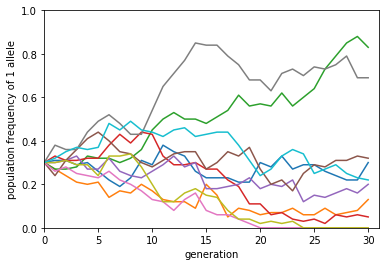

In [13]:
### 13
for pop in pops:
    pop.plotTraj();
plt.xlabel("generation")
plt.ylabel("population frequency of 1 allele") 

Now that we know it works, let's explore this a bit numerically. Try to get at least 1000 runs, it'll make graphs prettier down the road.  

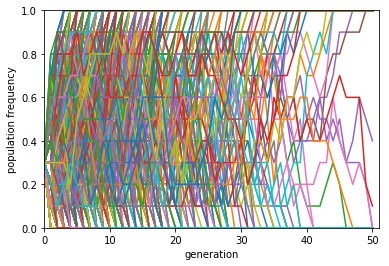

In [14]:
### 14
nInd = 10 
nGen = 50
nRuns = 1000
p0 = 0.3 
pops = [population(nInd, p0) for i in range(nRuns)] 
for pop in pops:
    pop.evolve(nGen); 
    pop.plotTraj()

plt.xlabel("generation")
plt.ylabel("population frequency") 


So there is a lot of randomness in there, but if you run it multiple times you should see that there is some regularity in how fast the allele frequencies depart from the initial values.  
To investigate this, calculate and plot the distribution of frequency at each generation. 

In [15]:
### 15
def frequencyAtGen(generation_number, populations, nBins=11):
    """calculates the allele frequency at generation genN for a list of populations pops. 
     Generates a histogram of the observed values"""
    counts_per_bin, bin_edge_positions = np.histogram([pop.traj[generation_number] for pop in populations], bins=nBins, range=(0,1)) 
    
    bin_centers=np.array([(bin_edge_positions[i+1]+bin_edge_positions[i]) / 2 for i in range(len(counts_per_bin))]) 
    return bin_centers, counts_per_bin # Return the data from which we will generate the plot

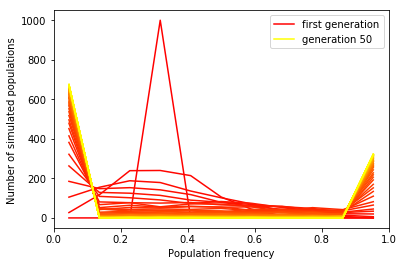

In [16]:
### 16
nBins = 11 # The number of frequency bins that we will use to partition the data.
for i in range(nGen+1):
    
    bin_centers, counts_per_bin = frequencyAtGen(i,pops); 
    if i==0:
        plt.plot(bin_centers, counts_per_bin, color=plt.cm.autumn(i*1./nGen), label="first generation")  # cm.autumn(i*1./nGen) returns the 
                                                                        #  color with which to plot the current line
    elif i==nGen:
        plt.plot(bin_centers, counts_per_bin, color=plt.cm.autumn(i*1./nGen), label="generation %d"% (nGen,))
    else:
        plt.plot(bin_centers, counts_per_bin, color=plt.cm.autumn(i*1./nGen))
plt.legend()
plt.xlabel("Population frequency")
plt.ylabel("Number of simulated populations ")


There are three important observations here:

    1-Frequencies tend to spread out over time 
    2-Over time, there are more and more populations at frequencies 0 and 1. (Why?)
    3-Apart from the 0 and 1 bins, the distribution becomes entirely flat.

### Answer:
A2. This property of fixation or loss of alleles can be seen in a fewer number of generations in simulations for smaller populations. It can generally be considered as a quirk of small populations. Due to the model we considered until this point which neglects the effects migration and mutation, due to random genetic drift, some populations will lose either the 0 or 1 allele thus making them fixed for the other allele. Without mutation or migration to bring back the allele into the gene pool, the populations slowly start to accumulate a constant allelic frequency of zero or one.
#### Reference: 
pg 575-576 of Tamarin R.H.-Principles of Genetics (2001)

A few alternate ways of visualizing the data: first a density map

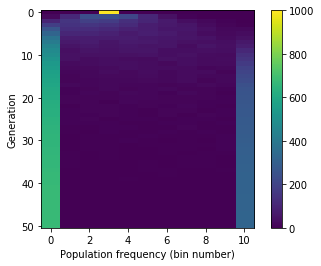

In [17]:
### 17
nBins = 11
sfs_by_generation = np.array([frequencyAtGen(i, pops, nBins=nBins)[1] for i in range(0, nGen+1)])
bins = frequencyAtGen(i, pops, nBins=nBins)[0]
plt.imshow(sfs_by_generation, aspect=nBins*1./nGen, interpolation='nearest')
plt.xlabel("Population frequency (bin number)")
plt.ylabel("Generation")
plt.colorbar()

Then a 3D histogram, unfortunately a bit slow to compute. 

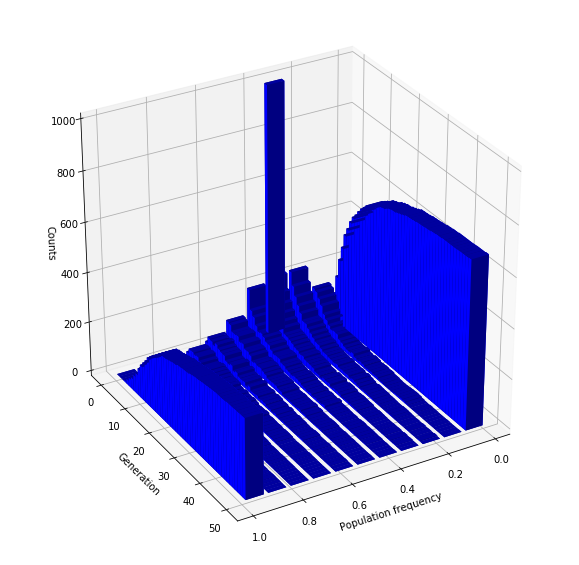

In [18]:
### 18
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d', elev=90)
xedges = bins
yedges = np.arange(nGen+1)

xpos, ypos = np.meshgrid(xedges-.4/nBins, yedges-0.5)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = 0 * ypos
dx = .8 / nBins
dy = 1
dz = sfs_by_generation.flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', edgecolor='none', alpha=0.15)

ax.view_init(elev=30., azim=60)
ax.set_xlabel("Population frequency")
ax.set_ylabel("Generation")
ax.set_zlabel("Counts")

plt.show()

Now let's dig into the effect of population size in a bit more detail.
Consider the change in frequency after just one generation: 

*Mathematical exercise (NOT optional)*:

* What is the expected distribution of allele frequencies after one generation, if they start at frequency $p$ in a population of size $N$? 
(Hint: we explored this numerically above!)
* What is the variance of this distribution? (Look it up if you don't know--wikipedia is useful for that kind of stuff)
    
        

### Answer:

The expected distribution is a binomial distribution which fits the data the best in th plot counts vs. number of alt_alleles. Also as the selection of an allele is not dependent on each other (independent events) we can model this experiment to follow a binomial distribution.

If the population frequency of the alt_allele initially is $p$ and size $N$ then the expected value in the next generation is np. For a single trial, this value will be $Np$/$N$ = $p$.

The variance of a binomial distribution is npq where $p$ is the number of successes and $q$ is the number of failures. In this case, the probability of success is $p$ and that of failure is 1-$p$. (As there are only two alleles for the gene) This makes the equation $npq$ to $Np$(1-$p$). For a single trial, the variance will be equal to $Np$(1-$p$)/$N$^2 = $p$(1-$p$)/$N$.


#### Reference: https://math.stackexchange.com/questions/226237/expected-value-of-a-binomial-distribution



To study the effect of population size on the rate of change in allele frequencies, plot the distribution of allele frequencies after nGen generation. Start with nGen=1 generation. 



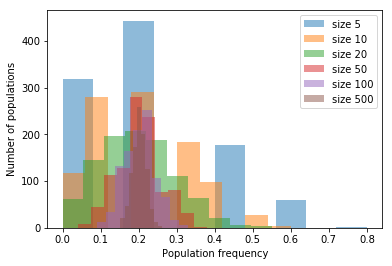

In [19]:
### 19
histograms = []
variances = []
p0 = 0.2
sizes = [5, 10, 20, 50, 100, 500] 
nGen = 1
for nInd in sizes:
    pops=[population(nInd,p0) for i in range(1000)] 
    [pop.evolve(nGen) for pop in pops]
    sample = [pop.getTraj()[-1] for pop in pops]
    variances.append(np.var(sample))
    histograms.append(plt.hist(sample, alpha=0.5, label="size %d" % (nInd,) ))
plt.xlabel("Population frequency")
plt.ylabel("Number of populations")
plt.legend()

So how does population size affect the change in allele frequency after one generation? Can you give a specific function describing the relationship between variance and population size? 

You can get this relationship from the math exercise above, or just try to guess it from the data. If you want to try to guess, start by plotting the variances (stored in "variances") against the population sizes (stored in "sizes"). Then you can either try to plot different functinoal forms to see if they fit, or you can change the way you plot the data such that it looks like a straight line. If you do the latter, make sure you update the labels!

Here I'm giving you a bit more room to explore--there are multiple ways to get there.  

### Answer:
As explored in the section above the relation between allele frequency and population size is equal to the expected value of allele frequency after one generation, and is equal to $p$.
The relation between the variance and population size is $p$(1-$p$)/$N$ as derived above.

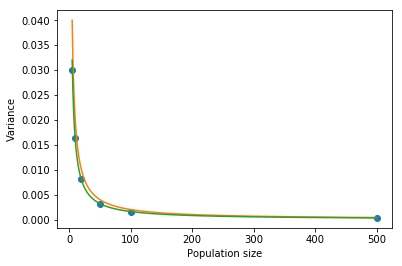

In [20]:
### 20
plt.plot(np.array(sizes), variances, 'o', label="simulation") #this is a starting point, but you can change this!
# Your theory.
x_axis = np.arange(5,500,0.1)
guess_1 = plt.plot(x_axis, p0/x_axis)
guess_1 = plt.plot(x_axis, (p0*(1-p0))/x_axis)
plt.xlabel("Population size") 
plt.ylabel("Variance")  

### Remarks: 
It seems that the expression $p0$/$N$ is a good estimator for the relationship between variance and the population size, however this appears so in the above case due to the small value of $p0$. If the frequency of the allele is larger as shown below (q0 is a new variable denoting frequency of the allele) we start to see a deviation from the predicted points.

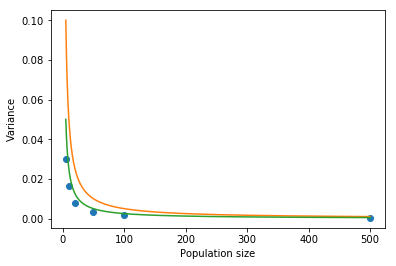

In [21]:
### 20
q0 = 0.5
plt.plot(np.array(sizes), variances, 'o', label="simulation") #this is a starting point, but you can change this!
# Your theory.
x_axis = np.arange(5,500,0.1)
guess_1 = plt.plot(x_axis, q0/x_axis)
guess_1 = plt.plot(x_axis, (q0*(1-q0))/x_axis, label="derived exp")
plt.xlabel("Population size") 
plt.ylabel("Variance") 

For short times, the expected changes in allele frequencies, $Var\left[E[(x-x_0)^2)\right]$, are larger for smaller population, a crucial result of population genetics. 

The next question is: How does the rate of change in allele frequency depend on the initial allele frequency? We can plot the histograms of allele frequency as before:


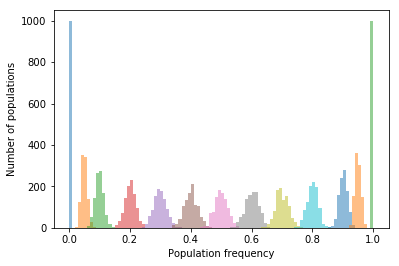

In [22]:
### 21
histograms = []
variances = []
p0_list = np.array([0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, .6, .7, .8, 0.9, 0.95, 1]) 
nGen = 1 
for p0 in p0_list:
    pops = [population(nInd, p0) for i in range(1000)] 
    [pop.evolve(nGen) for pop in pops]
    sample = [pop.getTraj()[-1] for pop in pops]
    variances.append(np.var(sample))
    histograms.append(plt.hist(sample, 100, alpha=0.5, range=(0,1)))
plt.xlabel("Population frequency")
plt.ylabel("Number of populations")

Find the relationship between initial frequency and variance. Again, this can be from the math exercise above, from looking it up, but you can also just try to guess it from the data--it's a simple function. 

Tips for guessing: 

First, make the plot of variance vs frequency below

Then consider how much variance there is for p0=0 and p0=1.  

Can you come up with a simple function that has these values? Hint: it's simpler than a trigonometric function. 




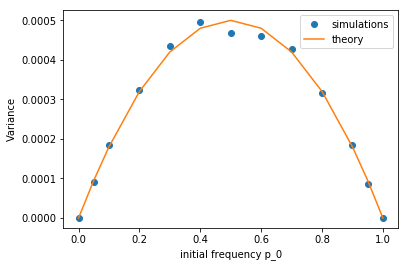

In [23]:
### 22
plt.plot(np.array(p0_list), variances, 'o', label="simulations")
plt.plot(np.array(p0_list), p0_list*(1-p0_list)/nInd, '-', label="theory")  # Your theory.  
plt.ylabel("Variance")
plt.xlabel(r"initial frequency p_0")
plt.legend()

Can you explain why this function is symmetrical around $p_0=0.5$?

### Answer:
The relation between allele frequency and variance at a single trial (in this case, at the first generation) is equal to $p(1-p)/size$. Hence this quadratic function gives values similar to the simulation as shown above.
This relation is symmetric about 0.5 due to the nature of the function, on differentiating once, we get 1 - 2$p$ =0, $p$ = 0.5. On differentiating again we get 2. Thus the point 0.5 is a local maxima as can be confirmed from the graph.

## Mutation
New mutations enter the population in a single individual, and therefore begin their journey at frequency $\frac{1}{N}$. Numerically estimate the probability that such a new mutation will eventually fix (i.e., the probability that the mutation reaches frequency 1) in the population, if no subsequent mutations occur. 



In [24]:
### 23

nInd = 10
nGen = 100
nRuns = 2000
#enter the initial allele frequency for new mutations
p0 = 1/nInd
pops = [population(nInd,p0) for i in range(nRuns)] 
[pop.evolve(nGen) for pop in pops]; 


We can plot the number of populations at each frequency, as we did above.

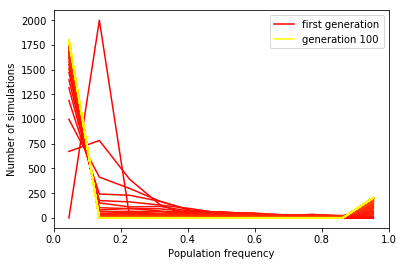

In [25]:
### 24
nBins = nInd + 1  # We want to have bins for 0,1,2,...,N copies of the allele. 
proportion_fixed = []  # fixation rate
for i in range(nGen+1):
    x,y = frequencyAtGen(i,pops);  
    if i==0:
        plt.plot(x, y, color=plt.cm.autumn(i*1./nGen), label="first generation")  # cm.autumn(i*1./nGen) returns the 
                                                                            #color with which to plot the current line
    elif i==nGen:
        plt.plot(x, y, color=plt.cm.autumn(i*1./nGen), label="generation %d"% (nGen,) )
    else:
        plt.plot(x, y, color=plt.cm.autumn(i*1./nGen))
    
    #we'll consider a population "fixed" if it is in the highest-frequency bin. It's
    #an approximation, but not a bad one if the number of bins is comparable to the 
    #population size.
    proportion_fixed.append((i, y[-1]*1./nRuns))
    
plt.legend()    
plt.xlabel("Population frequency")
plt.ylabel("Number of simulations")

Here you should find that most mutations fix at zero frequency--only a small proportion survives. 

*What is the probability that a new mutation fixes in the population?*--solve this problem both mathematically and numerically.  

The mathematical part requires almost no calculation or mathematical knowledge, once you think about it in the right way.  

Your mathematical solution:

### Answer:

For a diploid population of size N and neutral mutation rate $μ$, the initial frequency of a novel mutation is simply 1/(2N), and the number of new mutations per generation is 2$Nμ$  . Since the fixation rate is the rate of novel neutral mutation multiplied by their probability of fixation, the overall fixation rate is 2$Nμ$*\(1/2$N$) = $μ$ . Thus, the rate of fixation for a mutation not subject to selection is simply the rate of introduction of such mutations.

In this case, the rate of introduction of the mutation is 1/*nInd*.

#### Reference:
https://en.wikipedia.org/wiki/Fixation_(population_genetics)#Probability


For the computational part, note that we already computed the proportion of fixed alleles vs time in the "proportion_fixed" variable. Make sure that the numerical value agrees with the mathematical expectation.

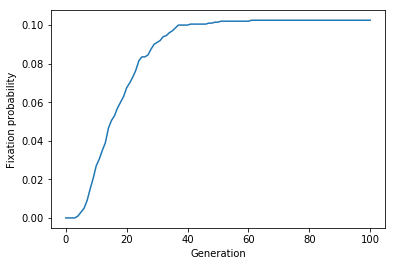

In [26]:
### 25
proportion_fixed = np.array(proportion_fixed)
plt.plot(proportion_fixed[:,0], proportion_fixed[:,1])
plt.xlabel("Generation")
plt.ylabel("Fixation probability")

# Additional Implementations to the Wright-Fischer Model.

## Heterozygosity

Heterozygosity can be thought of as the (expected) probability that an individual will be heterozygous at a given locus and tells us about the structure and history of the population. In population genetics, it gives us an idea of how long fixation takes to occur.

Heterozygosity at a generation(n) is defined as:

H(n) = $ \frac{2p(2N-p)}{2N(2N-1)} $

The value of heterozygosity at time(n):

h(n) = (1 - $ \frac{1}{2N} $)$^n$ * H(0)


### Reference: 
Probability Models for DNA Sequence Evolution by Rick Durrett (pg 7)

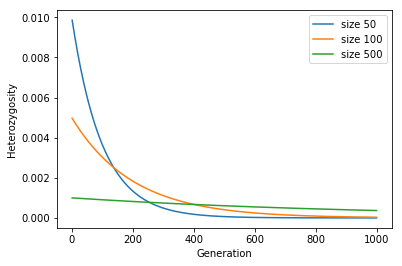

In [27]:
sizes = [50,100,500]
p0 = 0.5

# Heterozygosity in the first generation using above formula H(0)
def H_zero(size):
    return ((2*p0)*(2*size-p0))/((2*size)*(2*size-1))

# The value of heterozygosity at generation x
def heterozy(x,nInd):
    return ((1-(1/(2*nInd)))**x)*H_zero(i)

# Helper function to plot the graph
def graph(nInd, x_range):  
    x = np.array(x_range)  
    y = heterozy(x,nInd)  
    plt.plot(x, y,label="size %d"% (i))  

# Calling the graph function for different sized populations over several generations.   
for i in sizes:
    graph(i, range(2, 1000)) 

plt.legend()
plt.xlabel("Generation")
plt.ylabel("Heterozygosity")
plt.show()  

The equation above shows that genetic variation tends to be reduced by genetic drift and that the rate of loss of variation due to drift is greater in smaller populations than in larger populations.

As the number of generations increase, that is, as x->infinity, the expected heterozygosity decreases to zero. This suggests that in the long-term all the genetic variation will be lost under the Wright-Fisher model.

## Selection

### Definition:
In a panmictic, population of constant size $N$, where individuals are of types $a$ and $A$, if generation at time $t$ consists of $k$ individuals of type $a$ and $N −k$ of type $A$ then, according to the Wright-Fisher Model with selection, the generation at time $t+1$ is formed by sampling independantly with replacement with,

P(a sampled) = $ \frac{k(1 + s)}{k(1 + s) + N − k} $

$s$ is called selection coefficient. We say that $a$, $A$ have relative fitness 1 + $s$ : 1.

### Reference:
Some mathematical models from population genetics. Lecture notes by Eric Luçon.

Link: http://www.stats.ox.ac.uk/~etheridg/orsay/

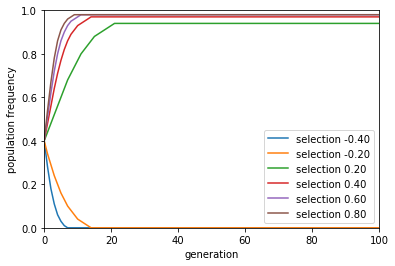

In [28]:
p0   = 0.4  # initial proportion of "1" alleles 
nInd = 100 # initial population size (number of individuals)

# Initialize a population of length nInd with only 0 alleles. 
initial_population = np.zeros(nInd)

# Set the first p0*nInd alleles to 1.
p1 = int(p0*nInd)
for i in range(p1):
    initial_population[i] = 1

# For added realism, shuffle the population so that the ones are distributed across the sample.
# You can use np.random.shuffle to do this.
np.random.shuffle(initial_population)

def generation(pop,selection_coefficient):
    """Takes in a list or array describing an asexual parental population. 
    Return a descendant population according to Wright-Fisher dynamics with constant size"""
    nInd = len(pop) #number of individuals. We could use the global definition of nInd, 
    #but it's better to use the information that is passed to the function 
    
    # Number of alleles that are '1'
    count_alt_alleles = 0
    for i in range(nInd):
        if(pop[i] == 1):
            count_alt_alleles +=1
            
    #Assume that s is the selection coefficient for '1' alleles   
    s = selection_coefficient  
    count_allele = nInd - count_alt_alleles
    
    # The probability is calculated from the above formula
    prob = (count_alt_alleles*(1+s))/(count_alt_alleles*(1+s)+count_allele)
    
    # Generating the offspring in accordance to selection
    num_alt_alleles = int(nInd*prob)
    new_pop = np.zeros(nInd)
    for i in range(num_alt_alleles):
        new_pop[i] = 1
    
    #Shuffling for adding realism
    np.random.shuffle(new_pop)   
    return new_pop

selection = [-0.4,-0.2,0.2,0.4,0.6,0.8]
for s in selection:
    nGen = 100  # number of generations to simulate
    history = [initial_population]  # a container list for our simulations. It will contain the population 
                                    # state after generations 0 to nGen
    for i in range(nGen):
        # evolve the population for one generation, and append the result to history.
        history.append(generation(history[i],s)) 
    history = np.array(history)  # convert the list into an array for convenient manipulation later on
    freqs = [np.mean(history[i]) for i in range(len(history))]
    plt.plot(freqs,label="selection %.2f"% (s))


plt.legend()
plt.axis([0, 100, 0, 1]);#define the plotting range
plt.xlabel("generation")
plt.ylabel("population frequency")

The graph shows how the selection coefficient $s$ effects the frequency of the alleles.

We can infer that:
1. If $s$ > 0 : $1 allele$ is said to be beneficial
2. If $s$ < 0 : $1 allele$ is said to be deterious
3. Greater values of $s$ cause the $1 allele$ to fix in fewer generations.

# Summary

Some important things that we've seen in this notebook:
* The Wright-Fisher model. Despite its simplicity, it is the basic building block of a large fraction of population genetics.
* In finite populations, sampling fluctuations are an important driver of allele frequency change.
* These sampling fluctuations cause larger frequency changes in smaller populations.
* These fluctuations mean that alleles eventually fix one way or another -- We need new mutations to maintain diversity within a population.
* For neutral alleles, the probability of new mutations fixing in the population is inversely proportional to the population size

# Something to think about. 

We'll get to selection, recombination, and linkage in the next exercises. In the meantime, you can think about the following:

* Verify numerically that different reproductive models gives similar behavior. You may look up the Moran Model, or come up with your own evolutionary model. 
* How much time will it take for a typical new mutation to reach fixation for different population sizes? 
* If you add a constant influx of new mutations, how will the distribution of allele frequency look like at any given point in time?





Copyright: Simon Gravel. Do not share of distribute this file without the written consent of the author. 